
# AI2 - Assignment 4 - Sentiment Analysis on tweets 

__Student's Credentials__: Vissarion Moutafis - sdi1800119


### Loading Hugging Face

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import re
seaborn.set_style("ticks")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")

import torch
import torch.nn as nn
import torchtext
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

!pip install transformers 
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
 

!pip install tqdm
from tqdm import tqdm, trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# CHANGE THIS ONLY
dir_path = '/content/drive/MyDrive/Collab-Datasets/Vaccine Sentiment Dataset/'
# dir_path = '../input/vaccine-sentiment-analysis/'


In [4]:
train_dt_path = dir_path + "vs_train.csv"
test_dt_path = dir_path + "vs_dev.csv"

In [5]:
train_df_raw = pd.read_csv(train_dt_path, index_col=0)
test_df_raw = pd.read_csv(test_dt_path, index_col=0)

train_df_raw.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [6]:
def clean_tweet(tweet):
  t = tweet.lower().strip(' ').strip('\t')
  t = re.sub(r'\s+', ' ', t)
  return t

In [7]:
train_df_raw['tweet'] = train_df_raw['tweet'].map(clean_tweet)
test_df_raw['tweet'] = test_df_raw['tweet'].map(clean_tweet)

In [8]:
y_train = train_df_raw.pop('label').to_numpy(dtype=np.int8).reshape(-1)
X_train = train_df_raw['tweet'].to_numpy()

y_test = test_df_raw.pop('label').to_numpy(dtype=np.int8).reshape(-1)
X_test = test_df_raw['tweet'].to_numpy()

In [9]:
class ClassifierDataset(torch.utils.data.Dataset):
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
        
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
        
  def __len__ (self):
    return len(self.X_data)

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

In [10]:
train_dataset = ClassifierDataset(X_train, y_train)

test_dataset = ClassifierDataset(X_test, y_test)

## Tweet Tokenization

We will use the BERT tokenizer from hugging face model. We will also create some examples to check the use of the tokenizer.

In [11]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [12]:
def get_input_embeddings(t): 
  x, y = t[0], t[1]
  x_ = tokenizer(x, padding='max_length', truncation=True, max_length=50)
  x_['input_ids'] = torch.LongTensor(x_['input_ids']).to(device)
  x_['token_type_ids'] = torch.LongTensor(x_['token_type_ids']).to(device)
  x_['attention_mask'] = torch.LongTensor(x_['attention_mask']).to(device) 
  # add positional encodings
  return x_, y

In [13]:
tokenized_train_dataset = train_dataset.map(get_input_embeddings)
train_loader = torch.utils.data.DataLoader(tokenized_train_dataset, batch_size=24) 


tokenized_test_dataset = test_dataset.map(get_input_embeddings)
test_loader = torch.utils.data.DataLoader(tokenized_test_dataset, batch_size=24)

## Model Creation

Use the pretrained Bert for Sequence Classification model, for 3-classes classification and train it on the given training set

In [14]:
torch.cuda.empty_cache()

In [15]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
model = model.to(device)

In [17]:
def training_step(model, optimizer, criterion, epoch_i, train_loader, eval_loader, history=None):
  torch.cuda.empty_cache()
  # 1 step of backprop with train/test error estimation
  total_loss = 0
      
  for _X, _y in train_loader:
    torch.cuda.empty_cache()
    X, y = _X, _y.type(torch.LongTensor).to(device)
    # set the gradients to zero for new estimation
    optimizer.zero_grad() 
    # forward pass
    y_pred = model(**X)[0]
    # compute loss 
    loss = criterion(y_pred, y)
    total_loss += loss.item()

    # backpropagate error
    loss.backward()
    # apply gradient clipping adjust model's parameters
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    optimizer.step()

  train_loss = total_loss/len(train_loader)

    # if the user provides with a history dict the training step will save the current epoch's train-test loss
  if history is not None: 
    history['train'].append(train_loss)

  return train_loss

def train_model(history, model, train_loader, test_loader, epochs, _lr):
  # set to training mode
  model.train()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr = _lr)

  pbar = tqdm(range(epochs))
  for epoch in pbar:
    train_loss = training_step(model, optimizer, criterion, epoch, train_loader, test_loader, history)
    pbar.set_description('Epoch {}: train loss: {}'.format(epoch, train_loss), refresh=True)

In [18]:
history = {'train':[], 'test':[]}
train_model(history, model, train_loader, test_loader, 3,  3e-5)

Epoch 2: train loss: 0.2598302428563078: 100%|██████████| 3/3 [19:03<00:00, 381.25s/it]


## Evaluation

Evaluate the sentiment analysis task.

In [19]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
"""
Print classification report, history plot and roc plot with roc score
"""
def print_stats(model, test_loader, history=None):
  # print the classification report
  softmax = torch.nn.Softmax(dim=-1).to(device)
  y_ = [] 
  y = []
  with torch.no_grad():
    for _X, _y in test_loader:
      torch.cuda.empty_cache()
      X, _y = _X, _y.type(torch.LongTensor).to(device)
      y_.append(model(**X)[0].to('cpu'))
      y.append(_y.to('cpu'))
  y_ = torch.concat(y_)
  y = torch.concat(y).detach().cpu().numpy()

  y_pred_proba = softmax(y_).detach().cpu().numpy()
  y_pred = y_pred_proba.argmax(axis=1).reshape((-1, 1))
  print(classification_report(y, y_pred, target_names=['neutral', 'anti-vax', 'pro-vax']))

  # print the history graph
  if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(30, 5))
    ax = axes[0]
    train_loss = history['train']
    test_loss = history['test']

    ax.plot(np.arange(len(train_loss)), train_loss, test_loss)
    ax.legend(['train_loss', 'validation_loss'])
  else:
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))

  ax = axes[-1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  y_test_one_hot = np.zeros((y.size, 3), dtype=np.int8)
  y_test_one_hot[np.arange(y.size), y.reshape(-1)] = 1
  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  ax.plot(fpr[0], tpr[0], fpr[1], tpr[1], 'orange', fpr[2], tpr[2], 'aqua', np.arange(0,2,0.2), np.arange(0,2,0.2), '--k')
  ax.legend([
             f"ROC-Class 'Neutral' (area = {np.round(roc_auc[0], 3)})",
             f"ROC-Class 'Anti-Vax' (area = {np.round(roc_auc[1], 3)})",
             f"ROC-Class 'Pro-Vax' (area = {np.round(roc_auc[2], 3)})"
  ])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

Model Stats:
              precision    recall  f1-score   support

     neutral       0.82      0.78      0.80      1065
    anti-vax       0.65      0.58      0.61       296
     pro-vax       0.72      0.78      0.75       921

    accuracy                           0.75      2282
   macro avg       0.73      0.71      0.72      2282
weighted avg       0.76      0.75      0.75      2282



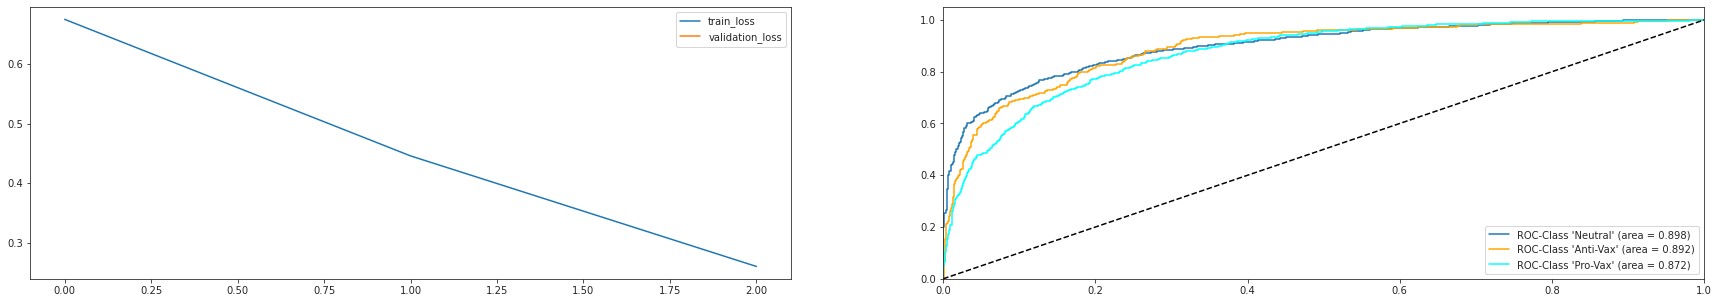

In [22]:
print("Model Stats:")
model.eval()
print_stats(model, test_loader, history)